# Figure C1: Sentinel-2 viewing angles algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm

from pycontrails.datalib import sentinel
from pycontrails.datalib.leo_utils import sentinel_metadata

In [2]:
handler = sentinel.Sentinel("gs://gcp-public-data-sentinel-2/tiles/31/U/DQ/S2B_MSIL1C_20210130T105209_N0209_R051_T31UDQ_20210130T120256.SAFE", "L1C_T31UDQ_A020383_20210130T105205", bands=["B10"])
ds = handler.get()

scale = 10 # change to 1 for pixel-level resolution. Set to 10 to speed up processing

In [3]:
tile_metadata_path, _ = handler._get_meta()

coarse_zenith, coarse_azimuth = sentinel_metadata.parse_viewing_incidence_angles(tile_metadata_path)

In [4]:
_, detector_band_metadata_path = handler._get_correction_meta()

detector_mask = sentinel_metadata.parse_high_res_detector_mask(detector_band_metadata_path, scale=scale)

In [ ]:
ds_viewing_angles = handler.get_viewing_angle_metadata(scale=scale) 
# takes roughly 3 minutes to fully process this image with scale=1. Put scale=10, or scale=100 to speed it up

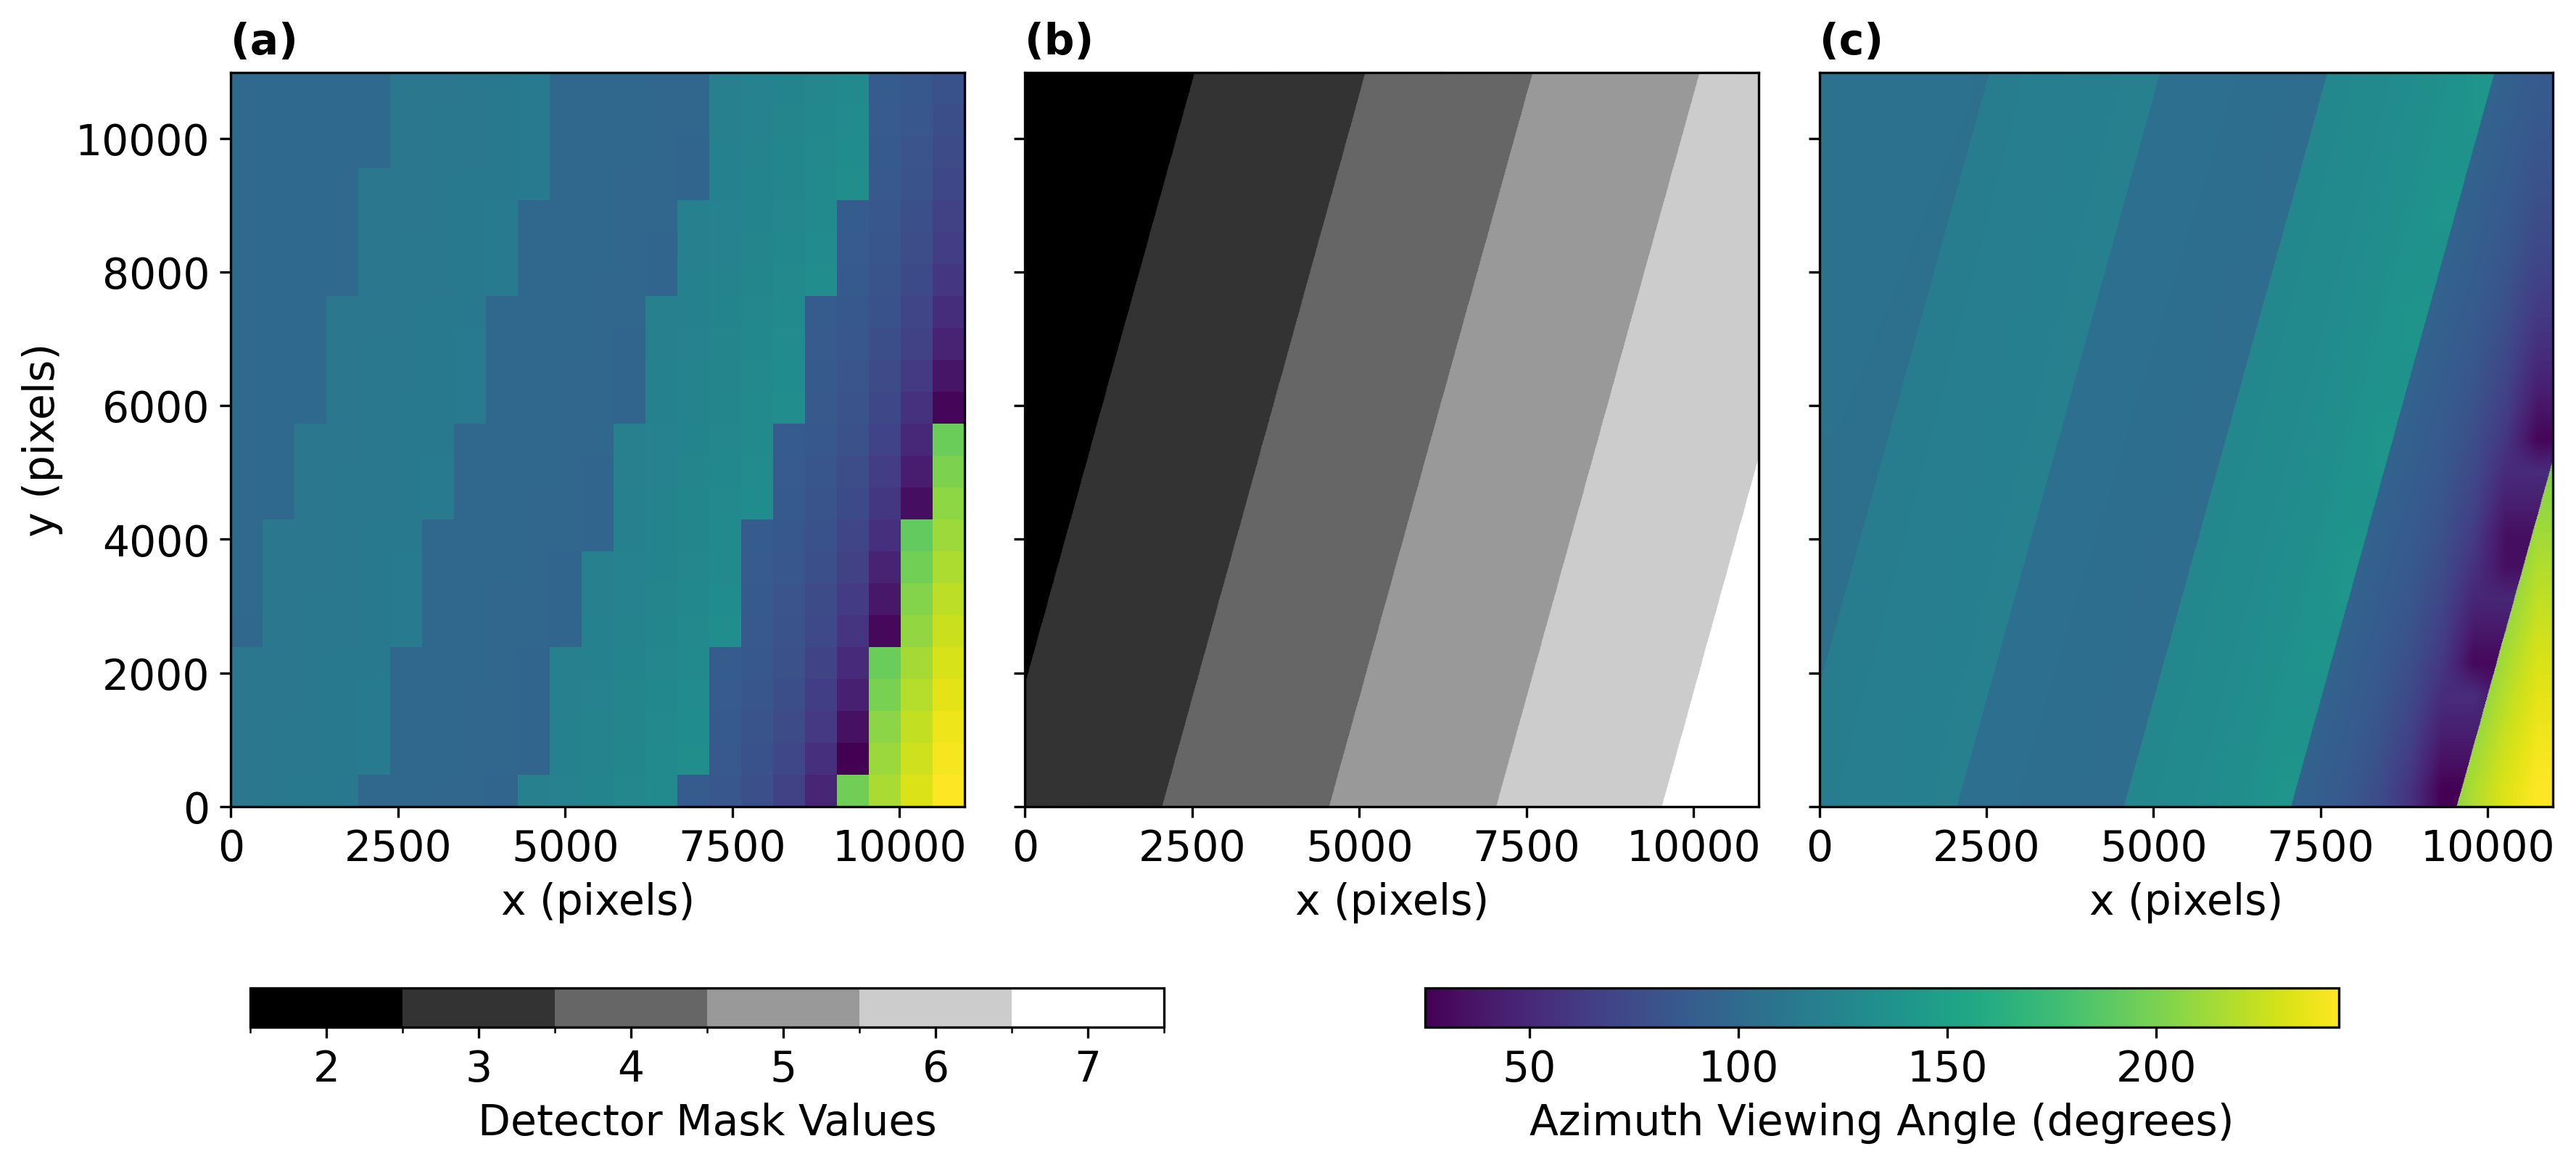

In [6]:
plt.rcParams.update({
    "axes.titlesize": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14
})

H, W = detector_mask.shape
H *= scale
W *= scale
extent = [0, W, 0, H]

vaa = ds_viewing_angles["VAA"].values

# Create the 1×3 subplot figure
fig, axs = plt.subplots(1, 3, figsize=(12, 6), dpi=300, sharey=True)

# Left: Coarse Azimuth
im1 = axs[0].imshow(coarse_azimuth, cmap="viridis", extent=extent)
axs[0].set_xlabel("x (pixels)")
axs[0].set_ylabel("y (pixels)")
axs[0].text(0.0, 1.07, "(a)", transform=axs[0].transAxes, fontsize=14, fontweight='bold', va='top')

# Middle: Detector Mask
levels = np.unique(detector_mask)
cmap = plt.get_cmap('gray', len(levels))  # Discrete grayscale
norm = BoundaryNorm(boundaries=np.append(levels, levels[-1]+1), ncolors=len(levels))
im2 = axs[1].imshow(detector_mask, cmap=cmap, norm=norm, extent=extent)
axs[1].set_xlabel("x (pixels)")
axs[1].text(0.0, 1.07, "(b)", transform=axs[1].transAxes, fontsize=14, fontweight='bold', va='top')

# Right: VAA from xarray
im3 = axs[2].imshow(vaa, cmap="viridis", extent=extent)
axs[2].set_xlabel("x (pixels)")
axs[2].text(0.0, 1.07, "(c)", transform=axs[2].transAxes, fontsize=14, fontweight='bold', va='top')

plt.tight_layout(rect=[0, 0.2, 1, 1])  # leave space below for colorbars

# Create custom axes for colorbars side by side
cbar_height = 0.03
cbar_bottom = 0.15

# Left colorbar: Detector mask
cbar_ax1 = fig.add_axes([0.1, cbar_bottom, 0.35, cbar_height])
tick_positions = levels + 0.5  # middle of each discrete interval
cbar1 = fig.colorbar(im2, cax=cbar_ax1, orientation='horizontal', ticks=tick_positions)
cbar1.set_label("Detector Mask Values")
cbar1.set_ticklabels(levels)  # set actual values as labels

# Right colorbar: Azimuth
cbar_ax2 = fig.add_axes([0.55, cbar_bottom, 0.35, cbar_height])
cbar2 = fig.colorbar(im1, cax=cbar_ax2, orientation='horizontal')
cbar2.set_label("Azimuth Viewing Angle (degrees)")

plt.savefig("figures/figC1.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()